# House Price Estimation From Visual and Textual Features
[Dataset on github](https://github.com/emanhamed/Houses-dataset)

## Contetns
* Data Understanding
* Textual Data Feature Engineering
* Visual Data Feature Engineering
* Exploratory Data Analysis
* Correlation Analysis
* Data Preprocessing
* Classic Machine Learning Modeling
* Advanced Machine Learning Modeling
* Neural Network Modeling

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate, Input, Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
sns.set(font_scale=1.3)

## Data Understanding
There are two types of data here, table and image. Firstly, let's load them.

Start with table

In [3]:
table_dir = 'data/HousesInfo.txt'
table = pd.read_csv(table_dir, header=None, sep=' ', names=['bedrooms', 'bathrooms', 'area', 'zipcode', 'price'])

In [4]:
table.shape

(535, 5)

In [4]:
table.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [5]:
info = pd.DataFrame(index=table.columns, columns=['Dtype', 'Unique Numbers'])
info['Dtype'] = table.dtypes
info['Unique Numbers'] = table.nunique()
info['Description'] = ['Number of bedrooms', 'Number of bathrooms', 'Area of the house', 'Zipcode', 'House price']

In [6]:
info

,Dtype,Unique Numbers,Description
bedrooms,int64,9,Number of bedrooms
bathrooms,float64,14,Number of bathrooms
area,int64,435,Area of the house
zipcode,int64,49,Zipcode
price,int64,369,House price


In [7]:
print('Duplicated Values:', table.duplicated().sum())

Duplicated Values: 5


In [8]:
print('Null Values:', table.isna().sum().sum())

Null Values: 0


In [9]:
info['Dtype'].value_counts()

int64      4
float64    1
Name: Dtype, dtype: int64

Let's see images. There are 4 images for each house which include bathroom, bedroom, kitchen and frontal.

The first house is shown below (There are 535 houses)

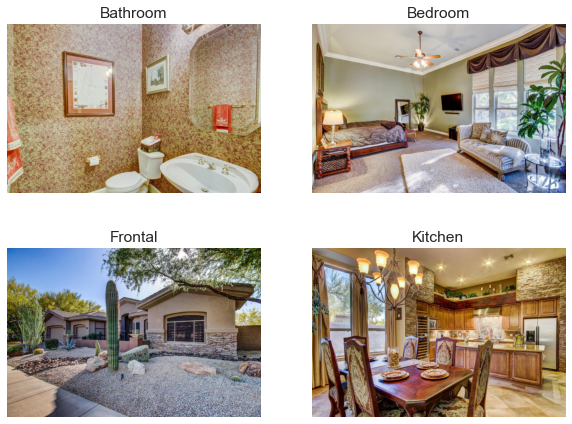

In [10]:
images_dir = 'data/Houses Dataset'
image_paths = sorted(list(glob.glob(os.path.sep.join([images_dir, "{}_*".format(1)]))))
fig, axes = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'hspace': -0.3})
for i, ax in enumerate(axes.flatten()):
    if i < len(image_paths):
        image = cv2.imread(image_paths[i])[..., ::-1]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(os.path.basename(image_paths[i]).replace('.jpg', '').replace('1_', '').title())
plt.show()

This function is used to read images with a fixed size. 

In this case the size is 256 meaning that a 256 * 256 matrix is created to represent visual data for each house. We divide the matrix into 4 parts and each part contains one image so each image is 128 * 128.

**The main reason behind it is because the minimum resolution is 187 and we do not want to increase it**

In [11]:
def img_read(size=256):
    images = []
    for i in table.index.values:
        basepath = os.path.sep.join(['data/Houses Dataset', "{}_*".format(i + 1)]).replace('\\', '/')
        imgPaths = sorted(list(glob.glob(basepath)))
        inputImages = []
        for imgPath in imgPaths:
            image = cv2.resize(cv2.imread(imgPath), (size // 2, size // 2))
            inputImages.append(image)
        outputImage = np.zeros((size, size, 3), dtype='uint8')
        outputImage[0:size // 2, 0:size // 2] = inputImages[0]
        outputImage[0:size // 2, size // 2:size] = inputImages[1]
        outputImage[size // 2:size, size // 2:size] = inputImages[2]
        outputImage[size // 2:size, 0:size // 2] = inputImages[3]
        images.append(outputImage)
    images = np.array(images)
    return images

In [12]:
images = img_read()

In [13]:
images.shape

(535, 256, 256, 3)

For the first house we have

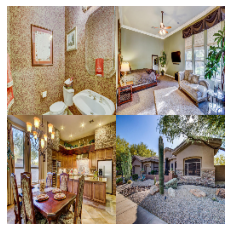

In [14]:
plt.imshow(images[0][..., ::-1])
plt.axis('off')
plt.show()

---
## Textual Data Feature Engineering
In this part we try some feature engineering methods for textual data only.

A new feature for total number of rooms

In [15]:
table['total rooms'] = table['bedrooms'] + table['bathrooms']

And there is a kitchen room so we add 1

In [16]:
table['total rooms'] = table['total rooms'] + 1

Now we create a feature to store average room area

In [17]:
table['avg_room_area'] = table['area'] // table['total rooms']

Create a category feature for area of the house

In [18]:
bins = [0, 2000, 4000, 6000, 8000, float('inf')]
labels = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
table['area category'] = pd.cut(table['area'], bins=bins, labels=labels, right=False)

Zipcode does not include important information and cannot help to improve our model

In [19]:
table.drop('zipcode', axis=1, inplace=True)

In [20]:
table.head()

,bedrooms,bathrooms,area,price,total rooms,avg_room_area,area category
0,4,4.0,4053,869500,9.0,450.0,Medium
1,4,3.0,3343,865200,8.0,417.0,Small
2,3,4.0,3923,889000,8.0,490.0,Small
3,5,5.0,4022,910000,11.0,365.0,Medium
4,3,4.0,4116,971226,8.0,514.0,Medium


In [21]:
table.shape

(535, 7)

## Visual Data Feature Engineering
Here we use **SIFT** method to extract features from image.

In [22]:
def SIFT(image, plot=True):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    if plot:
        image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
        plt.title('Image with Keypoints')
        plt.axis('off')
        plt.show()
    else:
        mean_array = np.mean(descriptors, axis=0)
        mean_array = mean_array.ravel()
        return mean_array

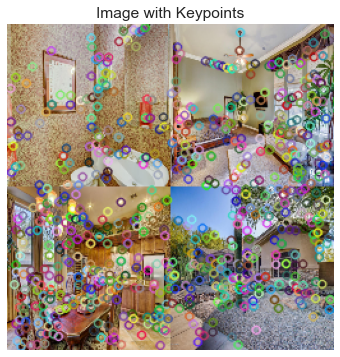

In [23]:
SIFT(images[0])

Apply SIFT method for all images

In [24]:
features = []
for img in images:
    feature = SIFT(img, plot=False)
    features.append(feature)

In [25]:
len(features)

535

In [26]:
features[0].shape

(128,)

In [27]:
sift_features = np.vstack(features)

So we have SIFT features array instead of the whole visual data

In [28]:
sift_features.shape

(535, 128)

## Exploratory Data Analysis
**Univariate Analysis**
* Target
* Numerical features
* Categorical features


**Bivariate Analysis**
* Target

In [29]:
table.describe().T.drop(['count', 'std'], axis=1)

,mean,min,25%,50%,75%,max
bedrooms,3.377570,1.0,3.0,3.0,4.0,10.0
bathrooms,2.664953,1.0,2.0,2.5,3.0,7.0
area,2364.904673,701.0,1440.0,2078.0,3067.5,9583.0
price,589362.811215,22000.0,249200.0,529000.0,728500.0,5858000.0
total rooms,7.042523,3.0,5.5,6.5,8.0,17.0
avg_room_area,324.558879,127.0,249.0,307.0,373.5,1597.0


Target

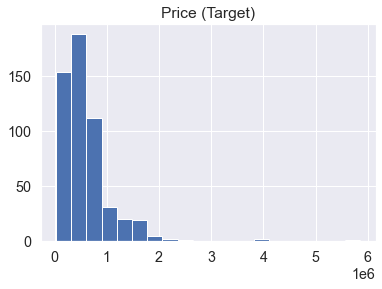

In [30]:
table['price'].hist(bins=20)
plt.title('Price (Target)')
plt.show()

Numerical features

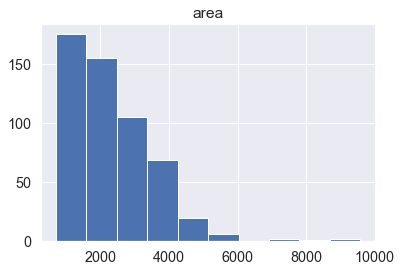

In [31]:
table[['area']].hist()
plt.show()

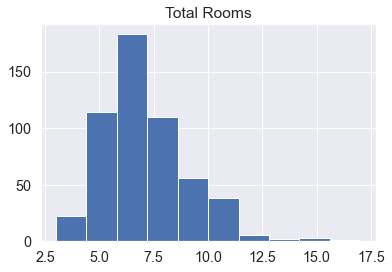

In [32]:
table['total rooms'].hist()
plt.title('Total Rooms')
plt.show()

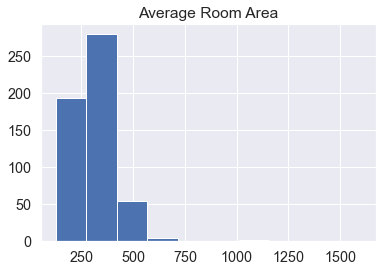

In [33]:
table['avg_room_area'].hist()
plt.title('Average Room Area')
plt.show()

Categorical features

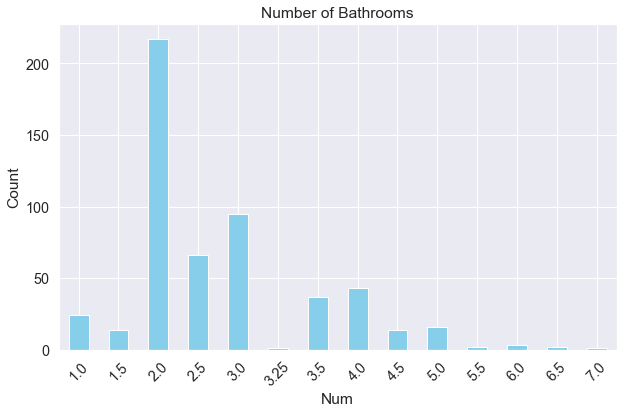

In [34]:
plt.figure(figsize=(10, 6))
table['bathrooms'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Bathrooms')
plt.xlabel('Num')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

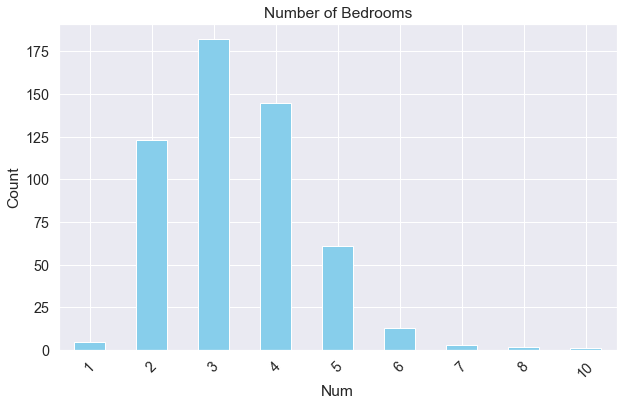

In [35]:
plt.figure(figsize=(10, 6))
table['bedrooms'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Bedrooms')
plt.xlabel('Num')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

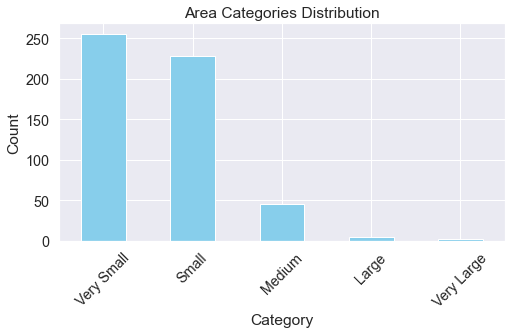

In [36]:
plt.figure(figsize=(8, 4))
table['area category'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Area Categories Distribution')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

**Bivariate analysis**

Here we visualize the impact of each feature on the target.

In [37]:
def price_vs_col(col):
    plt.scatter(table[col], table['price'])
    plt.title('Price vs ' + col.title().replace('_', ' '))
    plt.xlabel(col.title().replace('_', ' '))
    plt.ylabel('Price')
    plt.show()

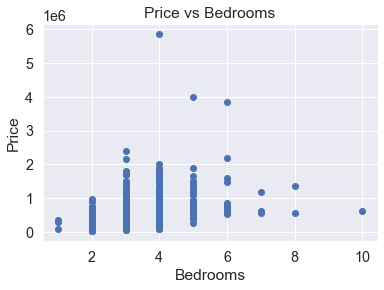

In [38]:
price_vs_col('bedrooms')

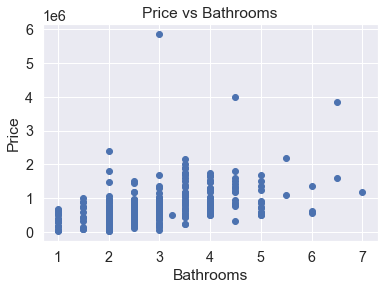

In [39]:
price_vs_col('bathrooms')

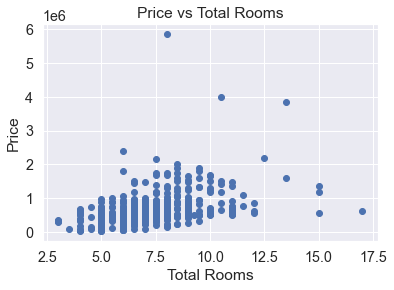

In [40]:
price_vs_col('total rooms')

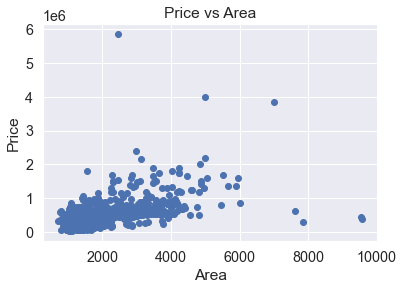

In [41]:
price_vs_col('area')

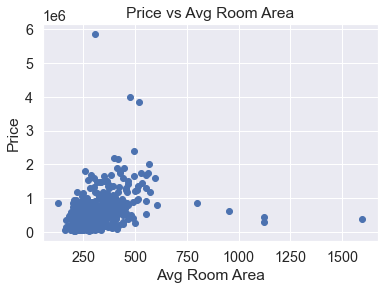

In [42]:
price_vs_col('avg_room_area')

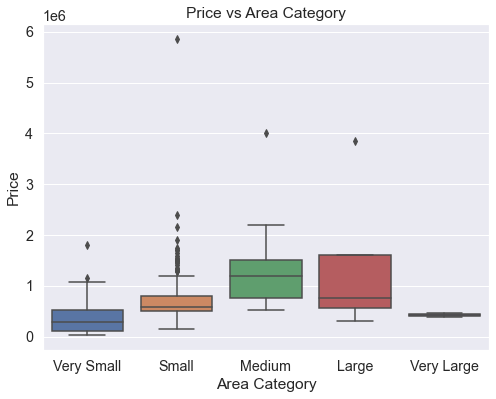

In [43]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='area category', y='price', data=table)
plt.title('Price vs Area Category')
plt.xlabel('Area Category')
plt.ylabel('Price')
plt.show()

## Correlation Analysis
* Correlation analysis
* Target correlation analysis

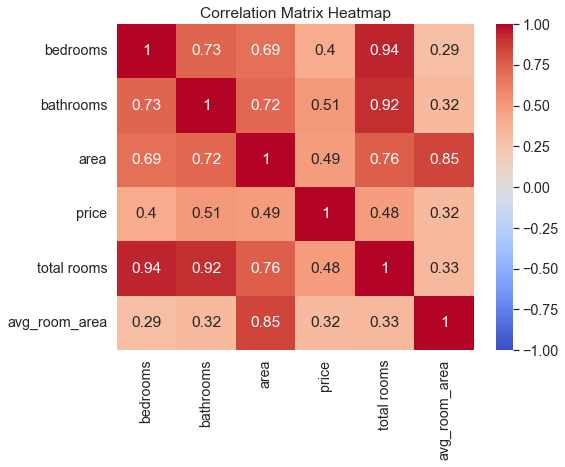

In [388]:
correlation_matrix = table.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [45]:
correlation_matrix['price'].sort_values(ascending=False)[1:]

bathrooms        0.505018
area             0.491725
total rooms      0.481455
bedrooms         0.398655
avg_room_area    0.315887
Name: price, dtype: float64

## Data Preproessing
* Feature scaling
* Log transform
* Train-test split
* Ordinal encoding

**Textual data preprocessing**

Ordinal encoding

In [48]:
table['area category'] = table['area category'].map({'Very Small': 1, 'Small': 2, 'Medium': 3,
                                                     'Large': 4, 'Very Large': 5})

In [116]:
X = table.drop('price', axis=1)
y = table['price']

Log transform

In [117]:
X[['area', 'avg_room_area']] = np.log1p(X[['area', 'avg_room_area']])

In [118]:
y = np.log1p(y)

In [119]:
print(X.shape)
print(y.shape)

(535, 6)
(535,)


Merging datasets

In [120]:
sift_features.shape

(535, 128)

In [121]:
X = np.hstack([sift_features, X])
X.shape

(535, 134)

Train-test split

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---
## Classic Machine Learning Modeling
* Linear Regression 
* Polynomial Regression
* Ridge Regression
* Decision Tree Regression

In [123]:
classic_results = {}

Linear Regression

In [124]:
def linear_regression():
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (mae, r2)

In [125]:
classic_results['Linear Regression'] = linear_regression()

In [126]:
classic_results

{'Linear Regression': (0.6009805536191507, 0.1664500299302707)}

Polynomial Regression

In [127]:
def poly_regression():
    model = make_pipeline(PolynomialFeatures(2), LinearRegression())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (mae, r2)

In [128]:
classic_results['Polynomial Regression'] = poly_regression()

In [129]:
classic_results

{'Linear Regression': (0.6009805536191507, 0.1664500299302707),
 'Polynomial Regression': (0.6860299331786008, -0.21689999671995608)}

Ridge Regression

In [130]:
def ridge_regression():
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (mae, r2)

In [131]:
classic_results['Ridge Regression'] = ridge_regression()

In [132]:
classic_results

{'Linear Regression': (0.6009805536191507, 0.1664500299302707),
 'Polynomial Regression': (0.6860299331786008, -0.21689999671995608),
 'Ridge Regression': (0.5841294829483957, 0.2242172702044294)}

Decision Tree Regression

In [136]:
def dtree_regression():
    model = DecisionTreeRegressor(max_depth=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (mae, r2)

In [138]:
classic_results['DTree Regression'] = dtree_regression()

In [139]:
classic_results

{'Linear Regression': (0.6009805536191507, 0.1664500299302707),
 'Polynomial Regression': (0.6860299331786008, -0.21689999671995608),
 'Ridge Regression': (0.5841294829483957, 0.2242172702044294),
 'DTree Regression': (0.45173110866564115, 0.4735366435733239)}

**Evaluation**

In [382]:
models = list(classic_results.keys())
first_values = [value[0] for value in classic_results.values()]
second_values = [value[1] for value in classic_results.values()]
sorted_models_first = [model for _, model in sorted(zip(first_values, models))]
sorted_models_second = [model for _, model in sorted(zip(second_values, models))]

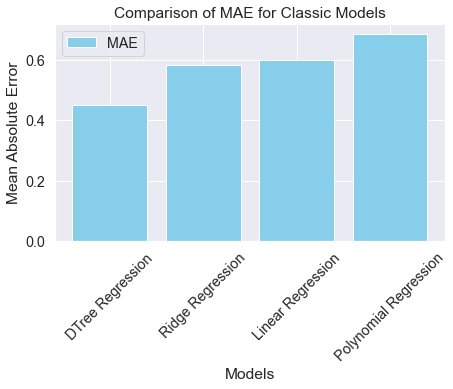

In [383]:
plt.figure(figsize=(7, 4))
plt.bar(sorted_models_first, sorted(first_values), color='skyblue', label='MAE')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of MAE for Classic Models')
plt.xticks(rotation=45)
plt.legend()
plt.show()

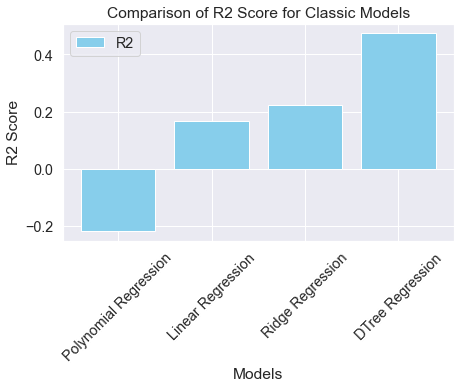

In [384]:
plt.figure(figsize=(7, 4))
plt.bar(sorted_models_second, sorted(second_values), color='skyblue', label='R2')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('Comparison of R2 Score for Classic Models')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Advanced Machine Learning Modeling
* Random Forest Regressor
* Support Vector Regressor
* CatBoost Regressor
* XGBoost Regressor

In [155]:
advanced_results = {}

Random Forest Regressor

In [216]:
def rf_regression():
    model = RandomForestRegressor(n_estimators=50, random_state=90)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (mae, r2)

In [218]:
advanced_results['Random Forest Regressor'] = rf_regression()

In [219]:
advanced_results

{'Random Forest Regressor': (0.4072896249459859, 0.5835694520181814)}

Support Vector Regressor

In [280]:
def svr():
    model = SVR(kernel='rbf', C=20, epsilon=0.5, degree=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (mae, r2)

In [282]:
advanced_results['Support Vector Regressor'] = svr()

In [283]:
advanced_results

{'Random Forest Regressor': (0.4072896249459859, 0.5835694520181814),
 'Support Vector Regressor': (0.5396160640892401, 0.35026739084912206)}

XGBoost Regressor

In [335]:
def xgboost():
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=8,
                             learning_rate=0.01, random_state=14, eval_metric='mae')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (mae, r2)

In [336]:
advanced_results['XGBoost Regressor'] = xgboost()

In [337]:
advanced_results

{'Random Forest Regressor': (0.4072896249459859, 0.5835694520181814),
 'Support Vector Regressor': (0.5396160640892401, 0.35026739084912206),
 'XGBoost Regressor': (0.43452555240046586, 0.5226964986865524)}

CatBoost Regressor

In [365]:
def catboost():
    model = CatBoostRegressor(iterations=100, depth=8, eval_metric='MAE', random_state=10, verbose=0, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (mae, r2)

In [367]:
advanced_results['CatBoost Regressor'] = catboost()

In [368]:
advanced_results

{'Random Forest Regressor': (0.4072896249459859, 0.5835694520181814),
 'Support Vector Regressor': (0.5396160640892401, 0.35026739084912206),
 'XGBoost Regressor': (0.43452555240046586, 0.5226964986865524),
 'CatBoost Regressor': (0.4335964132765608, 0.5196737205964967)}

**Evaluation**

In [385]:
models = list(advanced_results.keys())
first_values = [value[0] for value in advanced_results.values()]
second_values = [value[1] for value in advanced_results.values()]
sorted_models_first = [model for _, model in sorted(zip(first_values, models))]
sorted_models_second = [model for _, model in sorted(zip(second_values, models))]

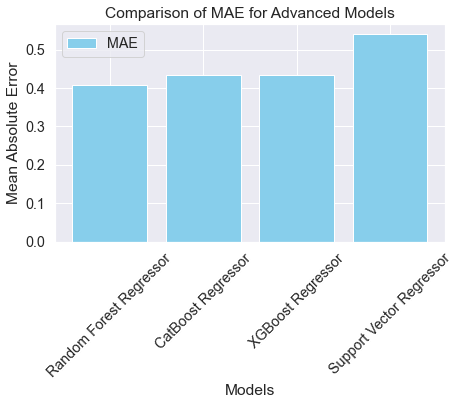

In [386]:
plt.figure(figsize=(7, 4))
plt.bar(sorted_models_first, sorted(first_values), color='skyblue', label='MAE')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of MAE for Advanced Models')
plt.xticks(rotation=45)
plt.legend()
plt.show()

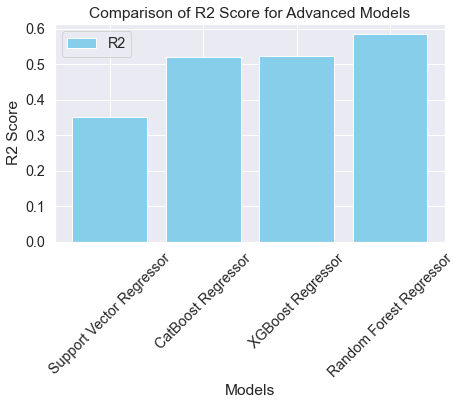

In [387]:
plt.figure(figsize=(7, 4))
plt.bar(sorted_models_second, sorted(second_values), color='skyblue', label='R2')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('Comparison of R2 Score for Advanced Models')
plt.xticks(rotation=45)
plt.legend()
plt.show()

---
## Neural Networks
In this part we use neural network approaches to estimate house prices.

The main neural networks used in this section are **MLP** and **CNN**.

This is our dataset

In [531]:
data = table.copy()

In [532]:
data.head()

,bedrooms,bathrooms,area,price,total rooms,avg_room_area,area category
0,4,4.0,4053,869500,9.0,450.0,3
1,4,3.0,3343,865200,8.0,417.0,2
2,3,4.0,3923,889000,8.0,490.0,2
3,5,5.0,4022,910000,11.0,365.0,3
4,3,4.0,4116,971226,8.0,514.0,3


In [533]:
images.shape

(535, 256, 256, 3)

**Preparing Data**

Here we don't use the same approach considering the fact that CNNs extract features in pictures and neural networks understand non-linear relationships. So we don't need feature engineering.

Let's preprocess data a bit

In [534]:
data = data[['bedrooms', 'bathrooms', 'area', 'price']]

After some tests and evaluations we found out that the best size for our images is 64 * 64

In [535]:
nn_images = img_read(size=64)

In [536]:
X_train, X_test, IX_train, IX_test = train_test_split(data, nn_images, random_state=5)

In [537]:
max_price = data['price'].max()
y_train = (X_train['price'] / max_price).values
y_test = (X_test['price'] / max_price).values

Standardization

In [538]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train[['bedrooms', 'bathrooms', 'area']])
X_test = ss.transform(X_test[['bedrooms', 'bathrooms', 'area']])

Training data

In [539]:
print(IX_train.shape)
print(y_train.shape)

(401, 64, 64, 3)
(401,)


Test data

In [540]:
print(IX_test.shape)
print(y_test.shape)

(134, 64, 64, 3)
(134,)


## NN Modeling
The model we decidede to use is a **Multi-channel CNN** with two channels, one for textual data and the other for visual data.
1. Visual data channel: CNN
2. Texual data channel: MLP

In [551]:
# CNN
input_shape = (64, 64, 3)
input1 = Input(shape=input_shape)
conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input1)
batchnorm1 = BatchNormalization(axis=-1)(conv1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(batchnorm1)

conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
batchnorm2 = BatchNormalization(axis=-1)(conv2)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(batchnorm2)

conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool2)
batchnorm3 = BatchNormalization(axis=-1)(conv3)
maxpool3 = MaxPooling2D(pool_size=(2, 2))(batchnorm3)

flatten1 = Flatten()(maxpool3)
dense1 = Dense(32, activation='relu')(flatten1)
batchnorm4 = BatchNormalization(axis=-1)(dense1)
dropout1 = Dropout(0.5)(batchnorm4)
dense2 = Dense(16, activation='relu')(dropout1)
m1 = Model(input1, dense2)

# MLP
m2 = Sequential()
m2.add(Dense(16, activation='relu', input_dim=3))
m2.add(Dropout(0.5))
m2.add(Dense(8, activation='relu'))
m2.add(Dense(4, activation='relu'))

# Combination
combinedModel = concatenate([m2.output, m1.output])

# Last layers
densef1 = Dense(8, activation='relu')(combinedModel)
densef2 = Dense(1, activation='linear')(densef1)
model = Model(inputs=[m2.input, m1.input], outputs=densef2)

In [552]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 64, 64, 16)   448         ['input_10[0][0]']               
                                                                                                  
 batch_normalization_36 (BatchN  (None, 64, 64, 16)  64          ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_27 (MaxPooling2D  (None, 32, 32, 16)  0           ['batch_normalization_36[0

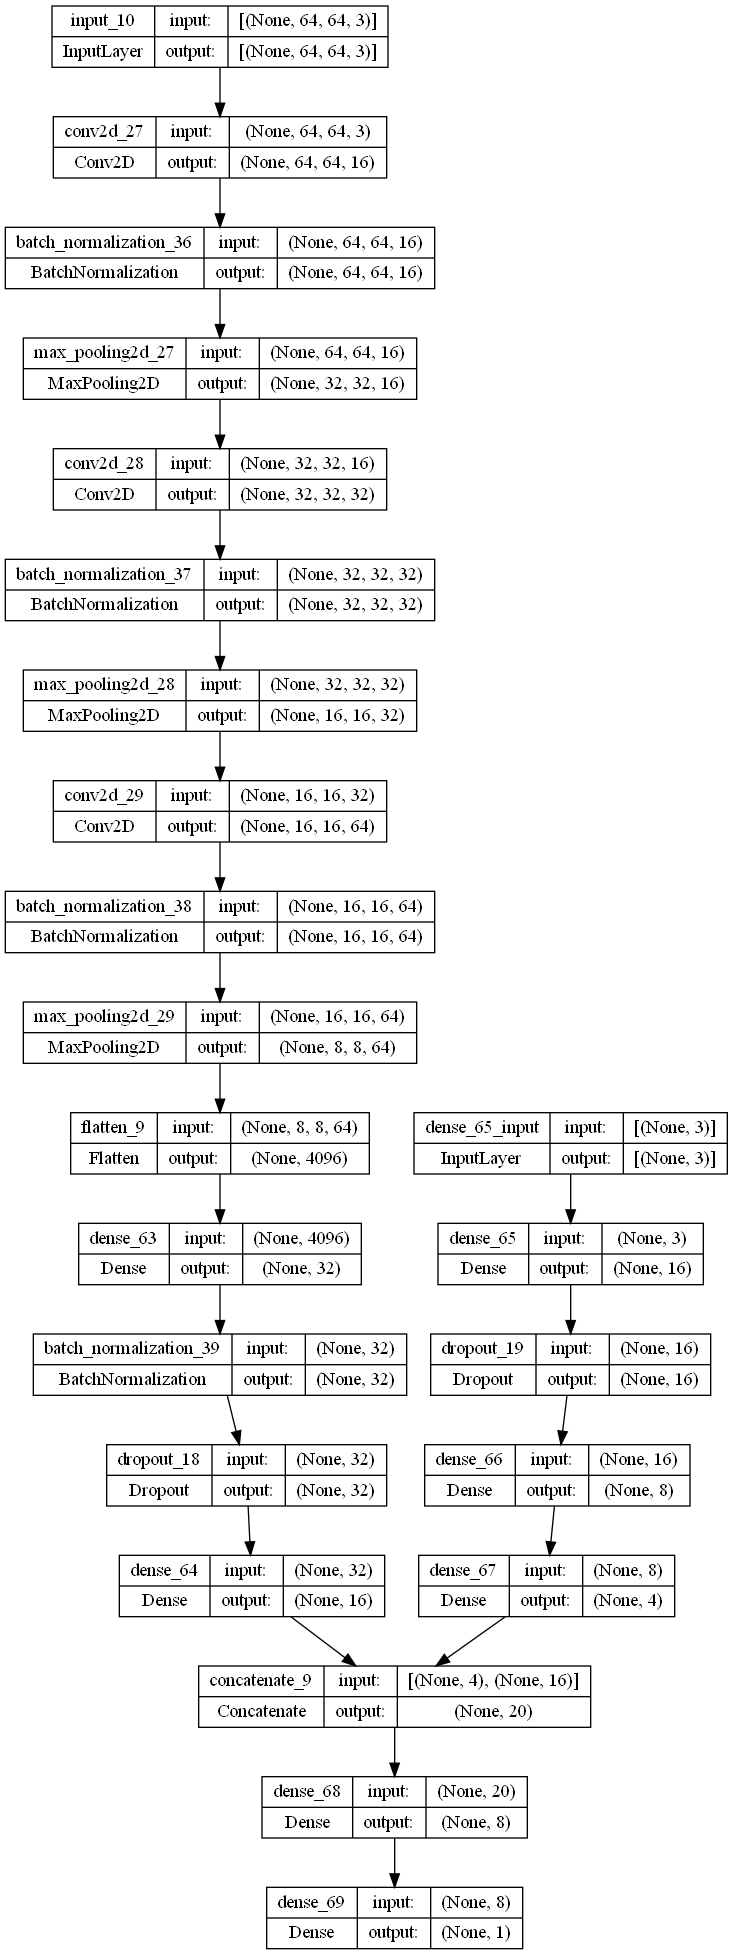

In [553]:
plot_model(model, show_shapes=True)

In [559]:
model.compile(loss='mean_absolute_error', optimizer=Adam(0.01))

In [560]:
history = model.fit([X_train, IX_train], y_train,
                    validation_data=([X_test, IX_test], y_test), epochs=84, batch_size=10)

Epoch 1/84
41/41 [==============================] - 3s 46ms/step - loss: 0.0287 - val_loss: 0.0461
Epoch 2/84
41/41 [==============================] - 2s 40ms/step - loss: 0.0333 - val_loss: 0.0404
Epoch 3/84
41/41 [==============================] - 2s 40ms/step - loss: 0.0291 - val_loss: 0.0439
Epoch 4/84
41/41 [==============================] - 2s 40ms/step - loss: 0.0280 - val_loss: 0.0423
Epoch 5/84
41/41 [==============================] - 2s 41ms/step - loss: 0.0298 - val_loss: 0.0479
Epoch 6/84
41/41 [==============================] - 2s 41ms/step - loss: 0.0320 - val_loss: 0.0435
Epoch 7/84
41/41 [==============================] - 2s 40ms/step - loss: 0.0300 - val_loss: 0.0500
Epoch 8/84
41/41 [==============================] - 2s 41ms/step - loss: 0.0345 - val_loss: 0.0494
Epoch 9/84
41/41 [==============================] - 2s 40ms/step - loss: 0.0305 - val_loss: 0.0412
Epoch 10/84
41/41 [==============================] - 2s 40ms/step - loss: 0.0269 - val_loss: 0.0441
Epoch 11/

41/41 [==============================] - 2s 42ms/step - loss: 0.0257 - val_loss: 0.0423
Epoch 84/84
41/41 [==============================] - 2s 42ms/step - loss: 0.0269 - val_loss: 0.0397


### Evaluation

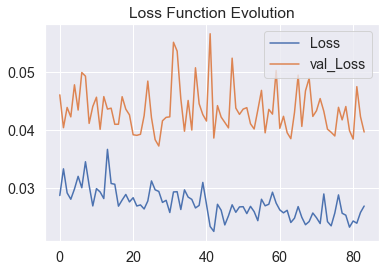

In [561]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()
plt.show()

In [562]:
predicts = model.predict([X_test, IX_test]) * max_price

5/5 [==============================] - 0s 27ms/step


In [563]:
r2_score(y_pred=predicts.flatten(), y_true=(y_test * max_price))

0.40193445545386564